# DWthon 3.0 by DATA WORKSHOP - прогнозирование опозданий трамваев в Кракове (на реальных данных)

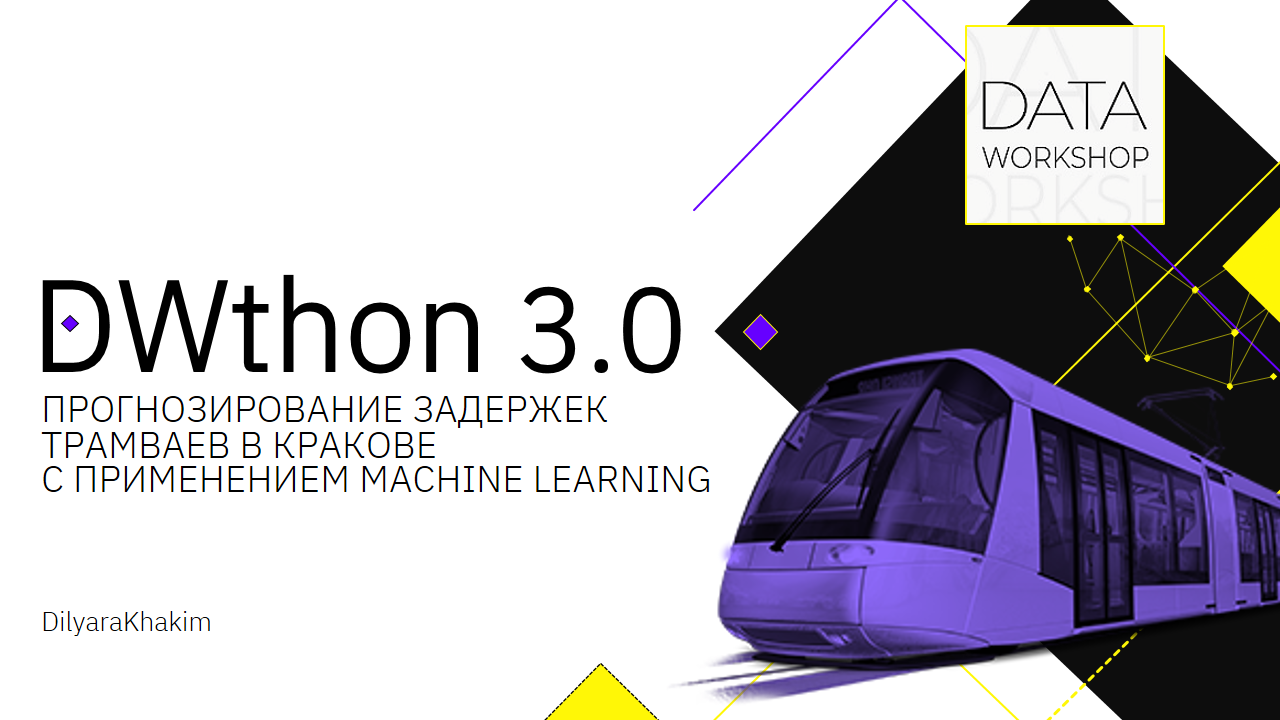

# Импортирование библиотек

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
np.random.seed(0)
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import eli5

# Импортирование данных

Одновременно импортируются `train` и `test`. 

In [ ]:
df_train = pd.read_hdf('../input/tram.train.h5')
df_test = pd.read_hdf('../input/tram.test.h5') #тестовый набор без ответов

# Предварительная обработка данных

## Объединение данных

In [ ]:
# Объединяем данные "df_train" и "df_test" и ответ записываем в "df":
df = pd.concat([df_train, df_test])

In [ ]:
# Подсчитаем параметры получившегося объединённого датасета:
df.shape

(308152, 11)

## Получение общего представления о данных

### Погрузимся более подробно в контекст исследуемых данных и получим более детализированное представление о данных

Описание имеющихся изначально признаков для данных:

‘id’ - ID строки

‘delay’ - опоздание трамвая (в секундах)

‘datetime’ - фактическое время прибытия трамвая

‘stop’ - ID остановки

‘stop_name’ - название остановки

‘number’ - номер трамвая

‘direction’ - направления трамвая (трамвай катается из точки А в точку Б и наоборот)

‘planned_time’ - ожидаемое время (когда трамвай должен приехать, согласно плана)

‘vehicle_id’ - ID трамвая

‘trip_id’ - ID маршрута (в течение дня, трамвай делает X маршрутов, и каждый из них имеет свой ID)

‘seq_num’ - порядковый номер маршрута (маршрут состоит из X остановок, каждую можно пронумеровать)

In [ ]:
df.head(10)

,id,delay,datetime,stop,stop_name,number,direction,planned_time,vehicle_id,trip_id,seq_num
0,0,0.0,2018-07-23 06:00:47,612,Borsucza,22,Walcownia,2018-07-23 06:00:00,6.352185e+18,6351558574044899587,7.0
1,1,0.0,2018-07-23 06:00:48,572,Smolki,11,Czerwone Maki P+R,2018-07-23 06:00:00,6.352185e+18,6351558574044670211,10.0
2,2,0.0,2018-07-23 06:00:49,322,Filharmonia,8,Bronowice Małe,2018-07-23 06:01:00,6.352185e+18,6351558574044592386,15.0
3,3,0.0,2018-07-23 06:00:51,363,Hala Targowa,1,Salwator,2018-07-23 06:01:00,6.352185e+18,6351558574044379394,24.0
4,4,0.0,2018-07-23 06:00:52,78,Batorego,24,Bronowice Małe,2018-07-23 06:00:00,6.352185e+18,6351558574044948738,19.0
5,5,0.0,2018-07-23 06:00:53,131,Dworzec Główny,52,Os.Piastów,2018-07-23 06:00:00,6.352185e+18,6351558574045030659,17.0
6,6,0.0,2018-07-23 06:00:54,715,Nowosądecka,24,Bronowice Małe,2018-07-23 06:00:00,6.352185e+18,6351558574044965123,3.0
7,7,0.0,2018-07-23 06:00:54,682,Prokocim Szpital,13,Bronowice,2018-07-23 06:00:00,6.352185e+18,6351558574044702978,5.0
8,8,60.0,2018-07-23 06:00:56,561,Lipska,50,Krowodrza Górka,2018-07-23 05:59:00,6.352185e+18,6351558574045022467,6.0
9,9,0.0,2018-07-23 06:00:57,368,Fabryczna,14,Bronowice Małe,2018-07-23 06:00:00,6.352185e+18,6351558574044739842,20.0


In [ ]:
df.tail(10)

,id,delay,datetime,stop,stop_name,number,direction,planned_time,vehicle_id,trip_id,seq_num
308136,308136,NaN,NaN,634,Wlotowa,50,Prokocim,2018-07-31 23:54:00,6.352185e+18,6351558574044995868,17.0
308137,308137,NaN,NaN,624,Kabel,24,Kurdwanów P+R,2018-07-31 23:53:00,6.352185e+18,6351558574044950804,22.0
308138,308138,NaN,NaN,589,Ruczaj,18,Czerwone Maki P+R,2018-07-31 23:56:00,6.352185e+18,6351558574044791061,23.0
308139,308139,NaN,NaN,634,Wlotowa,13,Nowy Bieżanów P+R,2018-07-31 23:56:00,6.352185e+18,6351558574044700948,22.0
308140,308140,NaN,NaN,2685,Jarzębiny,1,Wzgórza K.,2018-07-31 23:53:00,6.352185e+18,6351558574044385555,28.0
308141,308141,NaN,NaN,89,Bronowice,14,Bronowice Małe,2018-07-31 23:55:00,6.352185e+18,6351558574044741905,33.0
308142,308142,NaN,NaN,2690,Kampus UJ,18,Czerwone Maki P+R,2018-07-31 23:57:00,6.352185e+18,6351558574044791061,24.0
308143,308143,NaN,NaN,133,Wesele,14,Bronowice Małe,2018-07-31 23:56:00,6.352185e+18,6351558574044741905,34.0
308144,308144,NaN,NaN,630,Bieżanowska,24,Kurdwanów P+R,2018-07-31 23:56:00,6.352185e+18,6351558574044950804,23.0
308145,308145,NaN,NaN,2691,Chmieleniec,18,Czerwone Maki P+R,2018-07-31 23:58:00,6.352185e+18,6351558574044791061,25.0


In [ ]:
df.describe()

,id,delay,stop,number,vehicle_id,trip_id,seq_num
count,308152.000000,175986.000000,308152.000000,308152.000000,3.081520e+05,3.081520e+05,305770.000000
mean,154075.500000,61.516825,931.646379,19.419835,6.352185e+18,6.351559e+18,13.718962
std,88955.964413,82.487711,1021.402262,16.429881,7.222269e+02,1.046391e+06,8.345978
min,0.000000,0.000000,61.000000,1.000000,6.352185e+18,6.351559e+18,1.000000
25%,77037.750000,0.000000,319.000000,6.000000,6.352185e+18,6.351559e+18,7.000000
50%,154075.500000,60.000000,561.000000,14.000000,6.352185e+18,6.351559e+18,13.000000
75%,231113.250000,120.000000,1049.000000,24.000000,6.352185e+18,6.351559e+18,20.000000
max,308151.000000,1140.000000,3176.000000,52.000000,6.352185e+18,6.351559e+18,37.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308152 entries, 0 to 308145
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            308152 non-null  int64  
 1   delay         175986 non-null  float64
 2   datetime      175986 non-null  object 
 3   stop          308152 non-null  int64  
 4   stop_name     308152 non-null  object 
 5   number        308152 non-null  int64  
 6   direction     308152 non-null  object 
 7   planned_time  308152 non-null  object 
 8   vehicle_id    308152 non-null  float64
 9   trip_id       308152 non-null  int64  
 10  seq_num       305770 non-null  float64
dtypes: float64(3), int64(4), object(4)
memory usage: 28.2+ MB


<AxesSubplot:>

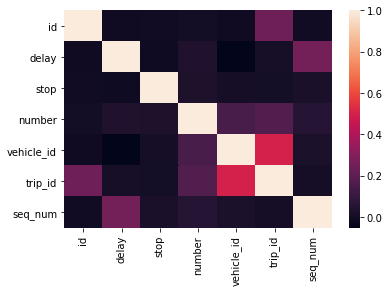

In [ ]:
# Визуализируем корреляции, существующие между изначально имеющимися в наборе данных "df_train" признаками
sns.heatmap(df_train.corr())

<AxesSubplot:>

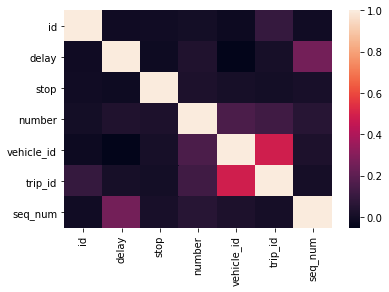

In [ ]:
# Визуализируем корреляции, существующие между изначально имеющимися в наборе данных "df" признаками
sns.heatmap(df.corr())

## Преобразование данных

In [ ]:
# Преобразование типа данных float в int:
df["vehicle_id"] = df["vehicle_id"].astype(int)

In [ ]:
# Видим, что в значениях признака "seq_num" имеются пропуски в количестве 2382 штук. Заменим их на значения "-1":
df["seq_num"] = df["seq_num"].fillna(-1)

In [ ]:
# Преобразование типа данных float в int:
df["seq_num"] = df.seq_num.astype(int)

In [ ]:
# Можем увидеть подтверждение результатов предшествующих преобразований:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308152 entries, 0 to 308145
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            308152 non-null  int64  
 1   delay         175986 non-null  float64
 2   datetime      175986 non-null  object 
 3   stop          308152 non-null  int64  
 4   stop_name     308152 non-null  object 
 5   number        308152 non-null  int64  
 6   direction     308152 non-null  object 
 7   planned_time  308152 non-null  object 
 8   vehicle_id    308152 non-null  int64  
 9   trip_id       308152 non-null  int64  
 10  seq_num       308152 non-null  int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 28.2+ MB


In [ ]:
df.describe()

,id,delay,stop,number,vehicle_id,trip_id,seq_num
count,308152.000000,175986.000000,308152.000000,308152.000000,3.081520e+05,3.081520e+05,308152.000000
mean,154075.500000,61.516825,931.646379,19.419835,6.352185e+18,6.351559e+18,13.605185
std,88955.964413,82.487711,1021.402262,16.429881,7.222269e+02,1.046391e+06,8.413005
min,0.000000,0.000000,61.000000,1.000000,6.352185e+18,6.351559e+18,-1.000000
25%,77037.750000,0.000000,319.000000,6.000000,6.352185e+18,6.351559e+18,7.000000
50%,154075.500000,60.000000,561.000000,14.000000,6.352185e+18,6.351559e+18,13.000000
75%,231113.250000,120.000000,1049.000000,24.000000,6.352185e+18,6.351559e+18,20.000000
max,308151.000000,1140.000000,3176.000000,52.000000,6.352185e+18,6.351559e+18,37.000000


### Поиск выбросов

In [ ]:
# Поиск аномальных значений для "delay":
df[df["delay"] > 850]

# Видим два аномально высоких значения - можно предположить, что в этих случаях, например, 
# могла произойти авария на пути следования

,id,delay,datetime,stop,stop_name,number,direction,planned_time,vehicle_id,trip_id,seq_num
20704,20704,1140.0,2018-07-23 13:22:41,3036,Szpital Narutowicza,5,Krowodrza Górka,2018-07-23 13:03:00,6352185295672180736,6351558574044494090,24
32374,32374,960.0,2018-07-23 17:16:09,409,Centralna,14,Mistrzejowice,2018-07-23 17:00:00,6352185295672180736,6351558574044760329,26


In [ ]:
# Исходя из этого, была выдвинута гипотеза о целесообразности удаления из исследуемого набора данных 
# строки с аномально высоким значением delay (1140.0). 
# Однако эта гипотеза на практике не подтвердилась: в результате удаления данной строки метрика успеха - 
# значение ошибки (MAE) - только увеличилось, вследствие чего данная строка в итоге не подверглась удалению.

# df = df[ df.index != 20704 ].reset_index(drop=True)

# Создаем признаки  (feature engineering)

### Признаки, связанные с компонентами даты и времени

In [ ]:
# С помощью pd.to_datetime сопоставляется planned_time с типом datetime, что упрощает работу с датами. 
# Например, можно извлечь время из этой даты
df["planned_time"] = pd.to_datetime( df["planned_time"] )

# Извлекается значение часа из "planned_time", т.к. целесообразно предположить, 
# что опоздания связаны с определёнными часами суток из-за разной степени загруженности дорог в течение суток:
df["planned_time_hour"] = df["planned_time"].dt.hour

In [ ]:
# Не включаем в модель признаки "datetime" и "planned_time", т.к. очевидно, 
# что зависимость с признаком "delay" непосредственная и прямая.

#### Не подтвердившиеся гипотезы

In [ ]:
# Также выдвигались и другие предположения об извлечении новых призаков из даты и времени.
# Однако эти гипотезы на практике не подтвердились: в результате добавления этих признаков в модель метрика успеха - 
# значение ошибки (MAE) - только увеличилось, вследствие чего данные признаки в конечном итоге 
# не были добавлены в состав модели.

In [ ]:
# В особенности оправданным казалось добавление признака дня недели,
# ведь некоторые дни отличаются большей загруженностью дорог, например, понедельник как начало рабочей недели
# или пятница как день, когда увеличивается интенсивность движения за город.
# Однако на практике при добавлении признаков, связанных с днём недели, значение ошибки напротив заметно возрастало.
# Вследствие чего данные признаки в итоге не были добавлены.
# Можно предположить, что движение именно трамваев не так сильно подвержено замедлению вследствие пробок.


# df["planned_time_day"] = df["planned_time"].dt.day_of_week
# df["planned_time_day"] = df["planned_time"].dt.weekday

In [ ]:
# Другие признаки, не вошедшие в итоге в состав модели:
    
# df["planned_time_day"] = df["planned_time"].dt.day
# df["planned_time_minute"] = df["planned_time"].dt.minute
# df["planned_time_second"] = df["planned_time"].dt.second
# df["planned_time_to_period"] = df["planned_time"].dt.to_period("D")
# df["planned_time_total_seconds"] = df["planned_time"].dt.total_seconds
# df["planned_time_quarter"] = df["planned_time"].dt.quarter

_____________

### Преобразование категориальных признаков

In [ ]:
df["stop_name_cat"] = df["stop_name"].factorize()[0]
df["direction_cat"] = df["direction"].factorize()[0]

### Добавление признаков, характеризующих остановки
Подсчёт статистики по остановкам. 
Добавим функцию "df_group_delay".

In [ ]:
def df_group_delay(df_train, groupby_feats):
    agg_params = {
        "mean_{}_delay".format("_".join(groupby_feats)): ("delay", "mean"),
        "median_{}_delay".format("_".join(groupby_feats)): ("delay", "median"),
        "count_{}_delay".format("_".join(groupby_feats)): ("delay", "count"),
        "std_{}_delay".format("_".join(groupby_feats)): ("delay", "std"),
        "count_zeros_{}_delay".format("_".join(groupby_feats)): ("delay", lambda vals: len([x for x in vals if x == 0]) ),
        "prob_zeros_{}_delay".format("_".join(groupby_feats)): ("delay", lambda vals: np.mean([x == 0 for x in vals]) ),
    }
    
    return df_train[groupby_feats + ["delay"]].groupby(groupby_feats).agg(
        **agg_params
    ).reset_index()


In [ ]:
# Воспользуемся "df_group_delay":
df_tmp = df_group_delay(df_train, ["stop_name"])
if "mean_stopname_delay" not in df:
    df = pd.merge(df, df_tmp, on="stop_name", how="left")

Теперь добавим направление движения (то есть "direction"). Остановка одна и та же, но движение трамвая может осуществляться в разные стороны, в результате чего это будут разные случаи:

In [ ]:
df_tmp = df_group_delay(df_train, ["stop_name", "direction"])
if "mean_stopname_direction_delay" not in df:
    df = pd.merge(df, df_tmp, on=["stop_name", "direction"], how="left")

In [ ]:
# df["seq_num_qcut7"] = pd.qcut( df["seq_num"], 7 )
# df_tmp = df_group_delay(df[ df["delay"].notnull() ], ["stop_name", "seq_num_qcut7"])
# if "mean_stop_name_seq_num_qcut7_delay" not in df:
#     df = pd.merge(df, df_tmp, on=["stop_name", "seq_num_qcut7"], how="left")

### Ряд гипотез по добавлению новых признаков, не нашедших в итоге подтверждения

In [ ]:
# Также выдвигались и другие предположения о добавлении новых призаков в модель.
# Однако эти гипотезы на практике не подтвердились: в результате добавления этих признаков метрика успеха - 
# значение ошибки (MAE) - только увеличивалось, вследствие чего данные признаки в конечном итоге 
# не были добавлены в состав модели.

#### Признак, характеризующий, является ли остановка конечной

In [ ]:
# Было выдвинута гипотеза, что если название остановки и название направления движения совпадают, 
# то можно считать данную остановку конечной (в этом случае присваивается значение 1, в обратном случае - 0).

In [ ]:
# df["is_the_end_of_direction"] = df.apply(lambda x: 1 if x["stop_name"] == x["direction"] else 0, axis=1)

#### Признак, характеризующий длину маршрута (т.е. максимальное количество остановок на маршруте) каждого конкретного номера маршрута трамвая

In [ ]:
df_pivot = df.pivot_table(index = ["number"], values = "seq_num", aggfunc= [np.max])
df_pivot 

,amax
,seq_num
number,
1,31
2,11
3,23
4,32
5,25
6,21
8,26
9,35


In [ ]:
df_pivot = df_pivot.reset_index()
df_pivot.columns = df_pivot.columns.droplevel(1)
df_pivot

,number,amax
0,1,31
1,2,11
2,3,23
3,4,32
4,5,25
5,6,21
6,8,26
7,9,35
8,10,27
9,11,21


In [ ]:
# df = df.merge(df_pivot, how = 'left', left_on='number', right_on='number')
# df

#### Признак, характеризующий, насколько данный остановочный пункт отдалён от конечного пункта на данном маршруте

Было выдвинуто предположение о том, что при приближении к концу маршрута происходит некое накапливание опоздания,
обусловленное куммулятивным эффектом

In [ ]:
# df["delta_from_max"] = df.apply(lambda x: (x["amax"] - x["seq_num"]), axis=1)

#### Признак, характеризующий, входит ли данный час в предполагаемый интервал "час-пик"

In [ ]:
# df["is_the_pick"] = df.apply(lambda x: 1 if ((x["planned_time_hour"] > 7 and x["planned_time_hour"] < 10) \
#                                              or (x["planned_time_hour"] > 17 and x["planned_time_hour"] < 20)) else 0, axis=1)

#### Признак, характеризующий, входит ли данный час в предполагаемую наиболее загруженную часть суток, которая была определена на основании анализа данных в разрезе временных интервалов на протяжении суток, которые приходятся на наибольшие значения задержек "delay"

In [ ]:
df_pivot = df.pivot_table(index = ["delay"], values = "planned_time_hour", aggfunc= [np.min, np.mean, np.max])
df_pivot 

,amin,mean,amax
,planned_time_hour,planned_time_hour,planned_time_hour
delay,,,
0.0,0,13.374930,23
60.0,0,13.395619,23
120.0,0,13.520519,23
180.0,0,13.768637,23
240.0,5,14.180947,23
300.0,5,14.477101,23
360.0,5,14.880654,23
420.0,7,15.206204,23


In [ ]:
# df["is_the_busy_part_of_day"] = df.apply(lambda x: 1 if (x["planned_time_hour"] > 14 and x["planned_time_hour"] < 18) else 0, axis=1)

# Выбор признаков

Были проигнорированы некоторые признаки, т.к. они не оказывают влияния на значение "delay" ("id", "vehicle_id", "trip_id").

In [ ]:
feats = df.select_dtypes("number").columns
black_list = ["id", "delay", "vehicle_id", "trip_id"]
feats = [x for x in feats if x not in black_list]
feats

['stop',
 'number',
 'seq_num',
 'planned_time_hour',
 'stop_name_cat',
 'direction_cat',
 'mean_stop_name_delay',
 'median_stop_name_delay',
 'count_stop_name_delay',
 'std_stop_name_delay',
 'count_zeros_stop_name_delay',
 'prob_zeros_stop_name_delay',
 'mean_stop_name_direction_delay',
 'median_stop_name_direction_delay',
 'count_stop_name_direction_delay',
 'std_stop_name_direction_delay',
 'count_zeros_stop_name_direction_delay',
 'prob_zeros_stop_name_direction_delay']

# Подготовка "X" и "y"

In [ ]:
df_train = df[ df["delay"].notnull() ].copy()
df_test = df[ df["delay"].isnull() ].copy()

X_train = df_train[feats].fillna(-1).values
y_train = df_train["delay"].values
X_test = df_test[feats].fillna(-1).values

# Тренировка модели и прогнозирование

In [ ]:
model = xgb.XGBRegressor(max_depth=5, n_estimators=50, random_state=0)
scores = cross_val_score(model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error")
np.mean(scores), np.std(scores)

(-48.54451432803966, 0.8066485712130129)

## Подбор гиперпараметров модели

### Попробуем рассмотреть различные варианты, чтобы получить первоначальные ориентиры

In [ ]:
model = xgb.XGBRegressor(max_depth=7, n_estimators=50, random_state=0)
scores = cross_val_score(model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error")
np.mean(scores), np.std(scores)

(-48.66601396787752, 0.7165781581479245)

In [ ]:
model = xgb.XGBRegressor(max_depth=9, n_estimators=50, random_state=0)
scores = cross_val_score(model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error")
np.mean(scores), np.std(scores)

(-49.115738011631, 0.6945342222766315)

In [ ]:
model = xgb.XGBRegressor(max_depth=9, n_estimators=50, learning_rate = 0.3, random_state=0)
scores = cross_val_score(model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error")
np.mean(scores), np.std(scores)

(-49.115738011631, 0.6945342222766315)

In [ ]:
model = xgb.XGBRegressor(max_depth=9, n_estimators=50, learning_rate = 0.1, random_state=0)
scores = cross_val_score(model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error")
np.mean(scores), np.std(scores)

(-48.41061157904892, 0.7730337317682715)

In [ ]:
model = xgb.XGBRegressor(max_depth=9, n_estimators=50, learning_rate = 0.05, random_state=0)
scores = cross_val_score(model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error")
np.mean(scores), np.std(scores)

(-47.77468656792961, 0.9927256022772236)

### В некоторой степени автоматизируем процесс подбора гиперпараметров, рассматримая сразу перебор в пределах интервалов значений для различных гиперпараметров:

In [ ]:
def check_model(max_depth, n_estimators, learning_rate, random_state=0):
    model = xgb.XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, random_state=random_state)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error")
    return np.mean(scores), np.std(scores)

In [ ]:
for depth_sequence in [9,10,11,12]:
    for estimators_sequence in [50,60,70,90]:
        for learning_rate_sequence in [0.04,0.03,0.02,0.01]:
            result_sequence = check_model(max_depth = depth_sequence, n_estimators = estimators_sequence, learning_rate = learning_rate_sequence)
            print(depth_sequence,'--', estimators_sequence,'--', learning_rate_sequence,'--', result_sequence)

9 -- 50 -- 0.04 -- (-47.59087596065371, 1.0974467360644873)
9 -- 50 -- 0.03 -- (-47.59537056320992, 1.249966173269898)
9 -- 50 -- 0.02 -- (-48.50051271338749, 1.4242442135229039)
9 -- 50 -- 0.01 -- (-52.312245121673904, 1.784949259476708)
9 -- 60 -- 0.04 -- (-47.74226061656993, 1.011774268080411)
9 -- 60 -- 0.03 -- (-47.54725332043855, 1.15858658309678)
9 -- 60 -- 0.02 -- (-47.95262335259317, 1.3398630835424352)
9 -- 60 -- 0.01 -- (-51.15610201208597, 1.6831274183628038)
9 -- 70 -- 0.04 -- (-47.914632871692824, 0.9507384116062595)
9 -- 70 -- 0.03 -- (-47.61613598811434, 1.07408194730506)
9 -- 70 -- 0.02 -- (-47.673410790113216, 1.278593800254162)
9 -- 70 -- 0.01 -- (-50.22092052468151, 1.5935495425447717)
9 -- 90 -- 0.04 -- (-48.16211124701517, 0.8624977767502559)
9 -- 90 -- 0.03 -- (-47.860429412196616, 0.968530333665104)
9 -- 90 -- 0.02 -- (-47.54271650204291, 1.1560130158292485)
9 -- 90 -- 0.01 -- (-48.94518260867115, 1.4695507158659273)
10 -- 50 -- 0.04 -- (-47.58277027843326, 1.05

### Итак, в качестве наиболее подходящих гиперпараметров модели, которые позволили добиться наименьшего значения ошибки MAE, были выбраны следующие:

In [ ]:
model = xgb.XGBRegressor(max_depth=10, n_estimators=60, learning_rate = 0.03, random_state=0)
scores = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error") #изменено cv=5 (изначально было cv=3)
np.mean(scores), np.std(scores)

(-47.448057576817355, 1.7225144106090207)

Теперь обучим модель прогнозированию:

In [ ]:
model = xgb.XGBRegressor(max_depth=10, n_estimators=60, learning_rate = 0.03, random_state=0)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=60, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Определение важности признаков

In [ ]:
eli5.show_weights(model, feature_names=feats)

Weight,Feature
0.7110,mean_stop_name_direction_delay
0.0350,planned_time_hour
0.0285,count_zeros_stop_name_direction_delay
0.0270,std_stop_name_direction_delay
0.0249,number
0.0232,prob_zeros_stop_name_direction_delay
0.0206,direction_cat
0.0171,median_stop_name_direction_delay
0.0169,count_stop_name_direction_delay
0.0139,count_zeros_stop_name_delay


In [ ]:
y_pred = model.predict(X_test)
y_pred[ y_pred < 0 ] = 0
df_test["delay"] = y_pred

In [ ]:
!mkdir -p ../output

# Запись результатов в файл  .csv

Сохраним и загрузим файл в Kaggle.

In [ ]:
df_test[ ["id", "delay"] ].to_csv('../output/prob_stopnames_direct_xgboost.csv', index=False) 

_____________________________________________________________________________________________